# AB tests

## Task  
A new post recommendation algorithm is proposed for our app. It is expected that the new algorithm will lead to an increase in CTR. To find out if it is true, we are going to run AB test.



In [1]:
#libraries
import pandas as pd
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib
import swifter
from scipy import stats
from scipy.stats import ttest_ind
%matplotlib inline


#database connection
connection = {'host': '',
'database':'',
'user':'',
'password':''
}

## AA test

At first we run AA test to ensure our groups are identical in terms of metrics to be compared

In [2]:
#getting number of likes and views, as well as their ratio for AA test
q = """
SELECT exp_group,
user_id,
sum(action = 'like') as likes,
sum(action = 'view') as views,
likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2025-11-14' and '2025-11-20'
and exp_group in (2,3)
GROUP BY exp_group, user_id
"""
df = ph.read_clickhouse(q, connection=connection)

display(df.head())
df.info()
df.groupby('exp_group').count()

,exp_group,user_id,likes,views,ctr
0,3,115383,38,248,0.153226
1,3,10326,24,132,0.181818
2,3,123580,25,122,0.204918
3,2,131473,19,98,0.193878
4,2,23985,12,44,0.272727


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16787 entries, 0 to 16786
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   exp_group  16787 non-null  int8   
 1   user_id    16787 non-null  uint32 
 2   likes      16787 non-null  uint64 
 3   views      16787 non-null  uint64 
 4   ctr        16787 non-null  float64
dtypes: float64(1), int8(1), uint32(1), uint64(2)
memory usage: 475.5 KB


,user_id,likes,views,ctr
exp_group,,,,
2,8362,8362,8362,8362
3,8425,8425,8425,8425


We have df with almost 17k rows, there are no null-values, which is good. Data types are correct.

In [3]:
# creating df for group 2 and 3
df_2 = df[df['exp_group'] == 2]
df_3 = df[df['exp_group'] == 3]

In [4]:
# histograms of likes, views and ctr in AA test groups
def group_histograms(df, group_name):
    metrics = ['likes', 'views', 'ctr']
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    
    for ax, metric in zip(axes, metrics):
        sns.histplot(
            data=df[metric],
            bins=50,
            ax=ax
        )
        ax.set_title(f'{group_name}: {metric}')
        ax.set_xlabel(metric)
        ax.set_ylabel('count')
    
    plt.tight_layout()
    plt.show()


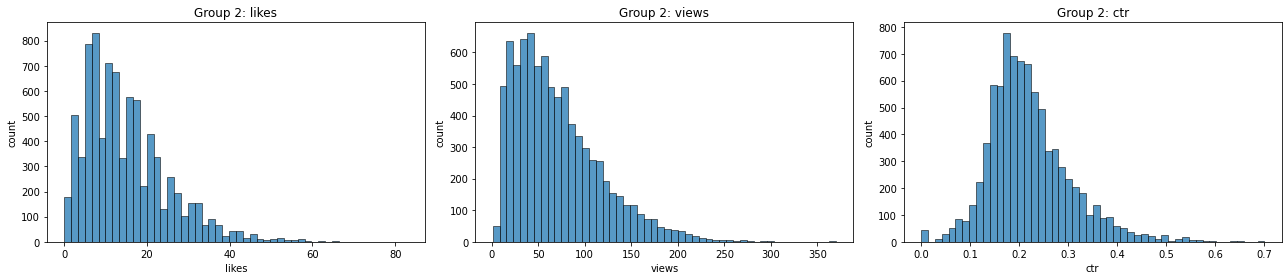

In [5]:
group_histograms(df_2, "Group 2")

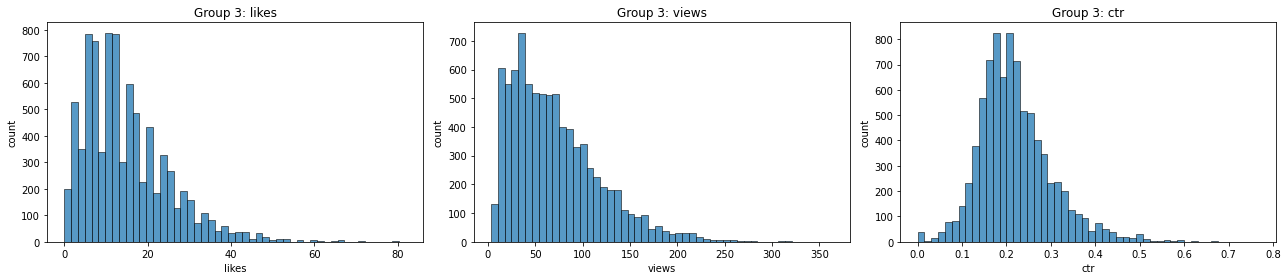

In [6]:
group_histograms(df_3, "Group 3")

<Axes: xlabel='likes', ylabel='Count'>

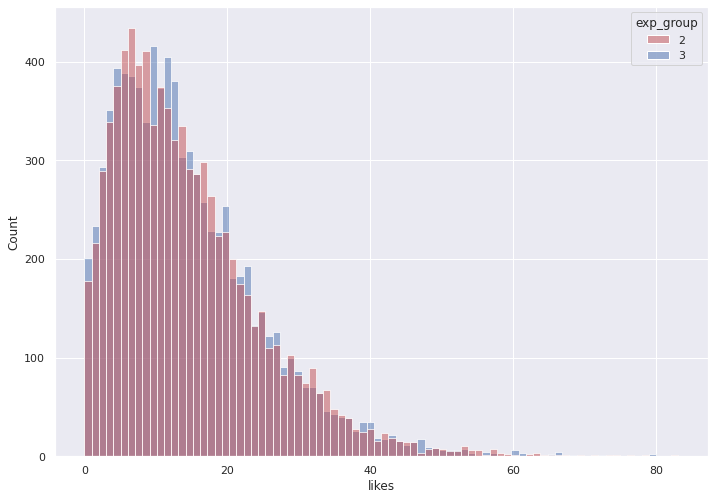

In [7]:
# historgrams overlay
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(data = df, x='likes', hue='exp_group', palette = ['r', 'b'], alpha=0.5, kde=False)

<Axes: xlabel='views', ylabel='Count'>

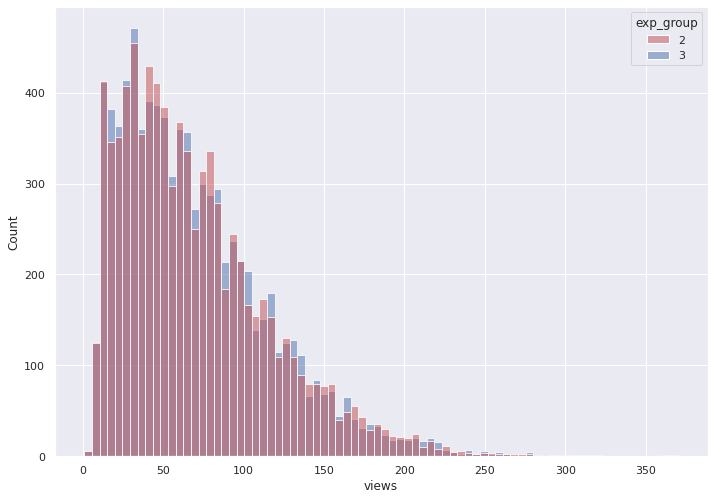

In [8]:
sns.histplot(data = df, x='views', hue='exp_group', palette = ['r', 'b'], alpha=0.5, kde=False)

<Axes: xlabel='ctr', ylabel='Count'>

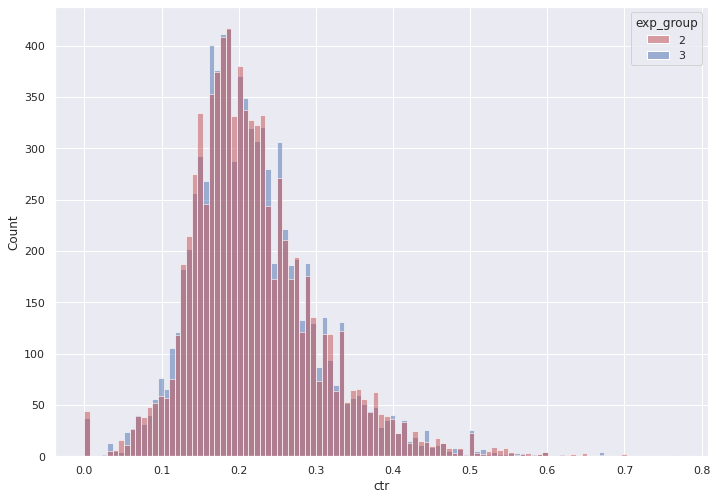

In [9]:
sns.histplot(data = df, x='ctr', hue='exp_group', palette = ['r', 'b'], alpha=0.5, kde=False)

Histogram for likes and views in both groups have close to normal distribution with a tail on the right. For ctr the distributions looks normal. Looking at the graphs, overlay histograms look similar, we will check it below using t-test. 

In [10]:
#caclulationg p-values for groups 2 and 3, taking 500 participants from each, repeat 10000 times
p_values = []

n_iter = 10_000
sample_size = 500

for _ in range(n_iter):
    sample_2 = df_2.sample(n=sample_size, replace=False)['ctr']
    sample_3 = df_3.sample(n=sample_size, replace=False)['ctr']
    
    stat, p = ttest_ind(
        sample_2,
        sample_3,
        equal_var=False
    )
    
    p_values.append(p)
    
p_values = np.array(p_values)

# the ratio of p-values which are below 0,05 (significance level)
print('The ratio of p-values below 0,05 is', (p_values < 0.05).mean())



The ratio of p-values below 0,05 is 0.0458


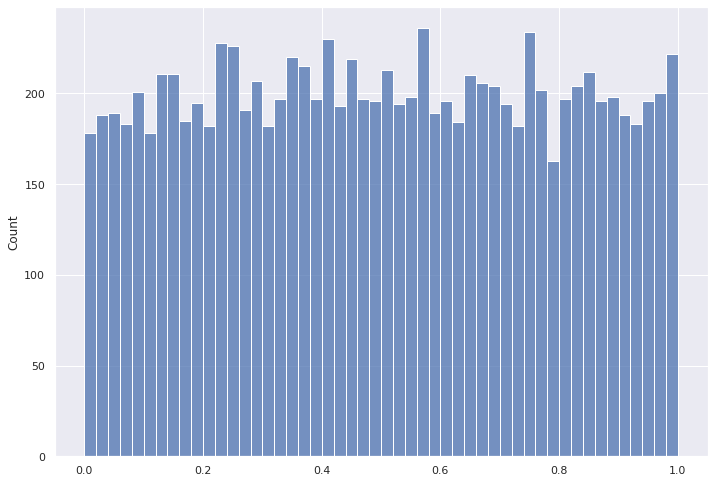

In [11]:
# checking distribution of p-values
groups = sns.histplot(data = p_values, bins=50)

### AA test conclusion 
The distribution obtained is uniform, and ratio of p-value < 0,05 is around 0,05. That is what we expected. Therefore, A/A test shows that groups are similar.

## AB test

The experiment was carried out from 2025-11-21 to 2025-11-27. Groups 2 and 1 were taken. 
*Group 2 used one of the new post recommendation algorithms, while group 1 served as a control.* 
The **main hypothesis** is that the new algorithm in group 2 will lead to an increase in CTR. 

In [12]:
q = """
SELECT exp_group,
user_id,
sum(action = 'like') as likes,
sum(action = 'view') as views,
likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2025-11-21' and '2025-11-27'
and exp_group in (1,2)
GROUP BY exp_group, user_id
"""
df_ab = ph.read_clickhouse(q, connection=connection)

display(df_ab.sample(10))
df_ab.info()

,exp_group,user_id,likes,views,ctr
12869,1,126273,5,45,0.111111
18622,2,131352,43,110,0.390909
11760,2,138832,5,61,0.081967
11588,1,127114,9,33,0.272727
11569,2,21894,29,95,0.305263
3363,1,109431,11,41,0.268293
10830,1,23452,42,175,0.240000
13280,2,122187,4,91,0.043956
6730,1,138337,9,39,0.230769
9160,1,22878,29,122,0.237705


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19897 entries, 0 to 19896
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   exp_group  19897 non-null  int8   
 1   user_id    19897 non-null  uint32 
 2   likes      19897 non-null  uint64 
 3   views      19897 non-null  uint64 
 4   ctr        19897 non-null  float64
dtypes: float64(1), int8(1), uint32(1), uint64(2)
memory usage: 563.6 KB


Almost 20k rows, no null-values, data types in all columns look correct

<Axes: xlabel='ctr', ylabel='Count'>

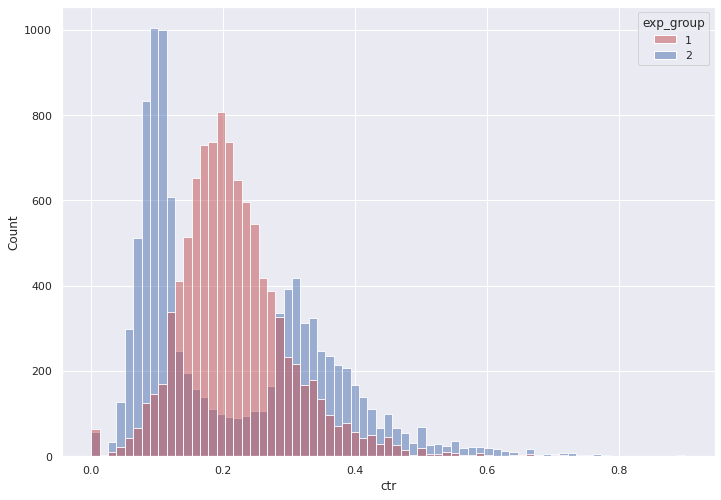

In [13]:
# Again let's have a look at ctr histograms for test groups
sns.histplot(data = df_ab, x='ctr', hue='exp_group', palette = ['r', 'b'], alpha=0.5, kde=False)

### Why bimodal distribution?

Group 2 shows bimodal distribution. To figure out why this might happen, we compare distribution of views and likes in both groups. We assume, that group 2 has many users with quite few likes.

<Axes: xlabel='likes', ylabel='Count'>

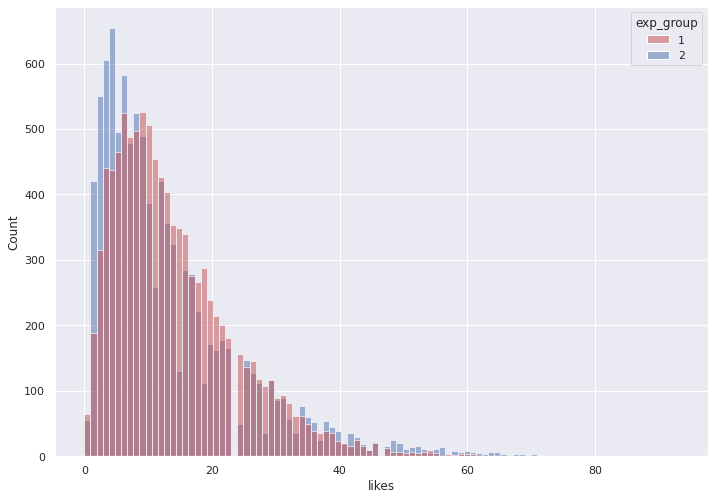

In [14]:
sns.histplot(data = df_ab, x='likes', hue='exp_group', palette = ['r', 'b'], alpha=0.5, kde=False)

<Axes: xlabel='views', ylabel='Count'>

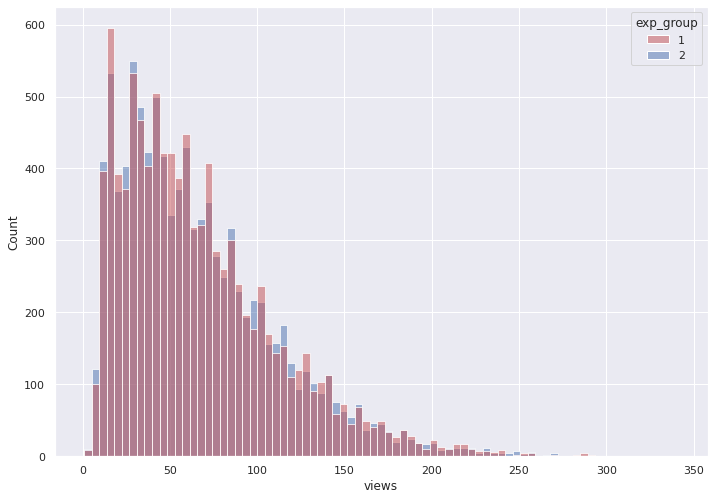

In [15]:
sns.histplot(data = df_ab, x='views', hue='exp_group', palette = ['r', 'b'], alpha=0.5, kde=False)

Views are distributed similarly in both groups, but likes for group 2 has more users with small number of likes compared to group 1

<Axes: xlabel='ctr', ylabel='Count'>

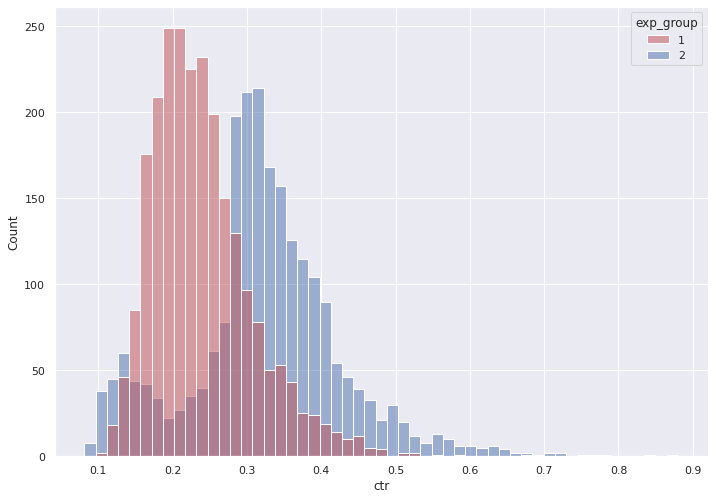

In [16]:
#how distribution of ctr looks like if we filter df by likes?
sns.histplot(data = df_ab[df_ab['likes'] >= 20], x='ctr', hue='exp_group', palette = ['r', 'b'], alpha=0.5, kde=False)

If we filter df by users who have more than 20 likes, distribution of ctr in group 2 changes and first peak (at ctr blose to 0) gets lower. It seems that the bimodal distribution of user CTR is due to the heterogeneity of user behavior and the **high dispersion of metrics with a small number of views**. Even with salted hashing, this effect is possible due to the random distribution of behavioral segments between groups.

In [17]:
# creating df for future stattesting
df_1_ab = df_ab[df_ab.exp_group == 1].copy()
df_2_ab = df_ab[df_ab.exp_group == 2].copy()

### T-test

In [18]:
alpha = 0.05 #significance level

stats.ttest_ind(df_1_ab.ctr, 
                df_2_ab.ctr, 
                equal_var=False)

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

*Having p > alpha (0,05) means that we cannot reject the null hipothesis that our mean ctr values in both groups are equal*

### Mann-Whitney test

In [19]:
stats.mannwhitneyu(df_1_ab.ctr, 
                   df_2_ab.ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)

In [20]:
A_gt_B = 0
for _ in range(10000):
    A_gt_B+= df_1_ab.ctr.sample().values[0] > df_2_ab.ctr.sample().values[0]
    
print('В', A_gt_B/100, '% случаев A > B. Should be around 50%')

В 55.7 % случаев A > B. Should be around 50%


*It seems there is difference between those two groups*

### Smothed ctr

In [21]:
# Global ctr
global_ctr_1 = df_1_ab.likes.sum()/df_1_ab.views.sum()
global_ctr_2 = df_2_ab.likes.sum()/df_2_ab.views.sum()

print('Global CTR for group 1', global_ctr_1, '\nGlobal CTR for group 2:', global_ctr_2)

Global CTR for group 1 0.2096041628394293 
Global CTR for group 2: 0.20025051027061783


<Axes: xlabel='smothed_ctr', ylabel='Count'>

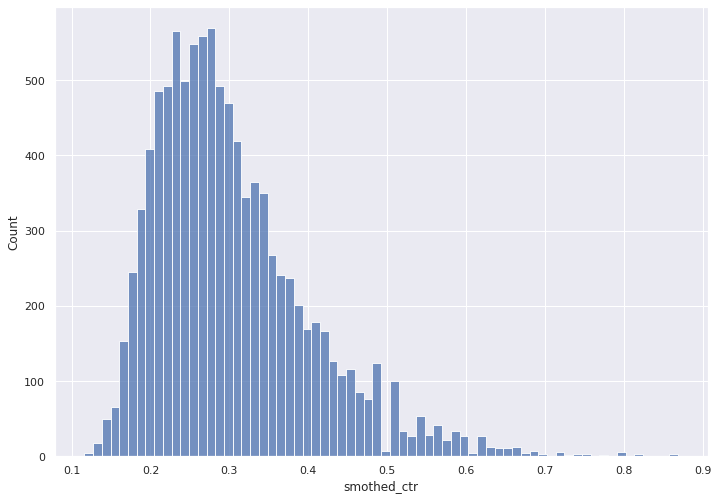

In [22]:
#function to calculate smothed ctr
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    return (user_likes + alpha + global_ctr)/(user_views + alpha)


df_1_ab['smothed_ctr'] = df_1_ab.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)
df_2_ab['smothed_ctr'] = df_2_ab.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

sns.histplot(df_1_ab.smothed_ctr, 
             kde = False)


<Axes: xlabel='smothed_ctr', ylabel='Count'>

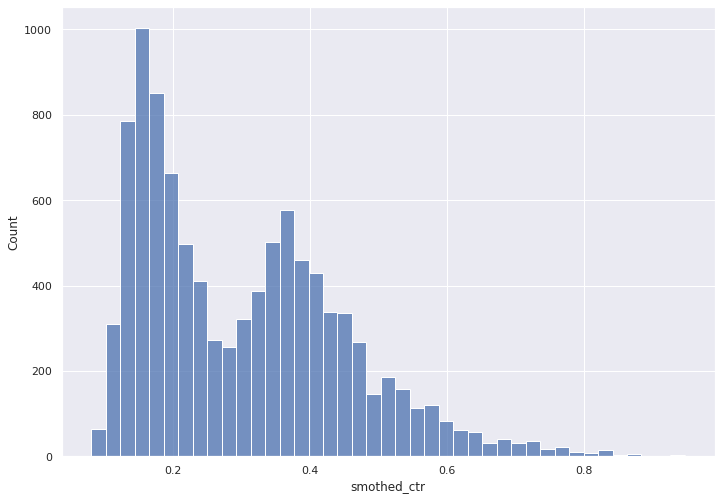

In [23]:
sns.histplot(df_2_ab.smothed_ctr, 
             kde = False)

**Applying stattests for smothed ctr**

In [24]:
stats.ttest_ind(df_1_ab['smothed_ctr'], 
                df_2_ab['smothed_ctr'], 
                equal_var=False)

Ttest_indResult(statistic=0.6645394515080321, pvalue=0.5063539822006945)

t-test shows that there are no evidences that H0 can be rejected. This is not really true since group 2 has distribution far from normal

In [25]:
stats.mannwhitneyu(df_1_ab['smothed_ctr'], 
                   df_2_ab['smothed_ctr'],
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=53491046.5, pvalue=4.504323016769142e-23)

In [26]:
A_gt_B = 0
for _ in range(10000):
    A_gt_B+= df_1_ab.ctr.sample().values[0] > df_2_ab.ctr.sample().values[0]
    
print('В', A_gt_B/100, '% случаев A > B. Should be around 50%')

В 55.67 % случаев A > B. Should be around 50%


Mann-Whitney shows again difference on the groups.

### Poisson's bootstrap

<Axes: ylabel='Count'>

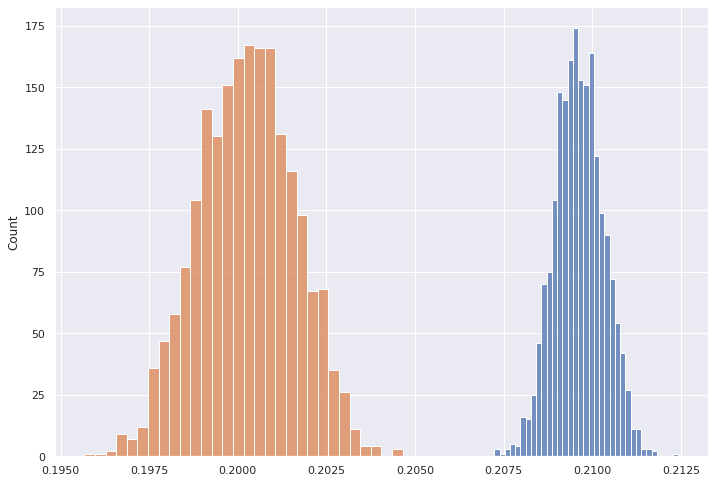

In [27]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2



likes1 = df_1_ab.likes.to_numpy()
views1 = df_1_ab.views.to_numpy()
likes2 = df_2_ab.likes.to_numpy()
views2 = df_2_ab.views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)

sns.histplot(ctr2)

<Axes: ylabel='Count'>

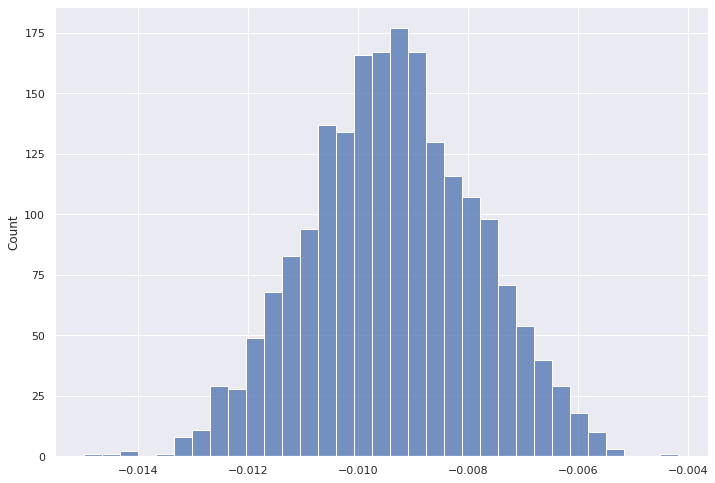

In [28]:
#global ctr difference
sns.histplot(ctr2 - ctr1)

CTR for group 2 is smaler that ctr for 1st group!

### Bucket conversion

In [29]:
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2025-11-21' and '2025-11-27'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df = ph.read_clickhouse(q, connection=connection)

#Mann-Whitney test
stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr,
                   df[df.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1997.0, pvalue=2.6576427804010095e-07)

In [30]:
#t-test

stats.ttest_ind(df[df.exp_group == 1].bucket_ctr,
                df[df.exp_group == 2].bucket_ctr, 
                equal_var = False)

Ttest_indResult(statistic=5.614819358149381, pvalue=4.592644937473873e-07)

**After bucket conversion both tests (Mann-Whitney and t-test) show difference between groups**

<Axes: xlabel='bucket_ctr', ylabel='Count'>

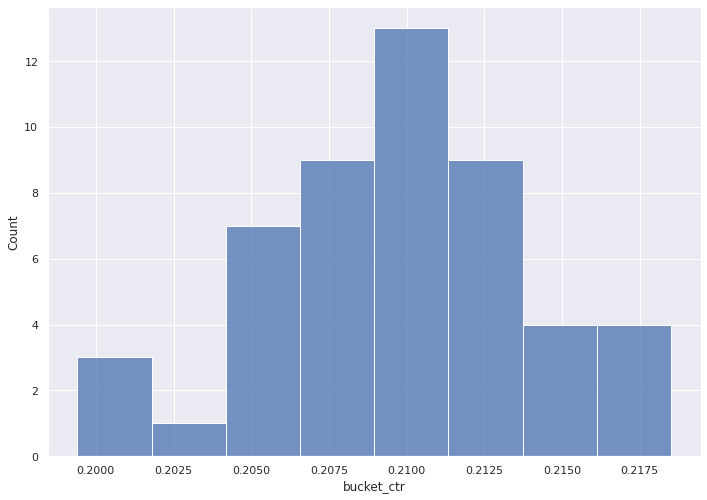

In [31]:
# checking the distribution 
sns.histplot(df[df.exp_group == 1].bucket_ctr)

<Axes: xlabel='bucket_ctr', ylabel='Count'>

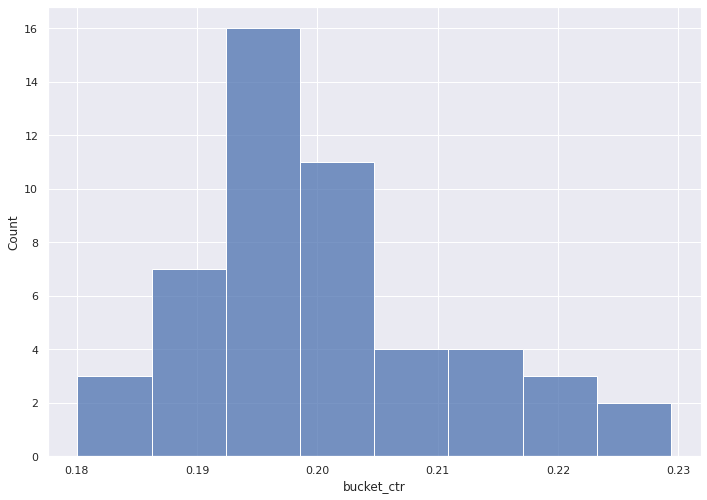

In [32]:
sns.histplot(df[df.exp_group == 2].bucket_ctr)

Bucket conversion transforms CTR distribution for both groups into normal distribution

## Conclusion

1. Based on results obtained CTR for Group 1 (control group) and CTR Group 2 (used one of the new post recommendation algorithms) of AB test are statistically different. Moreover, Group 2 CTR is smaller than CTR for control group, which means **there is negative outcome of the new post recommendation algorithms. Hence, it is not recommended to apply the new post algorithms to all users.**
2. T-test showed that AB test groups are similar probably because of clearly bimodal distribution of CTR in group 2. All other tests are less sensitive to the distributions, therefore, they did not show that AB test groups are different.
3. It seems that the bimodal distribution of user CTR is due to the heterogeneity of user behavior and the **high dispersion of metrics with a small number of views**. Even with salted hashing, this effect is possible due to the random distribution of behavioral segments between groups.


## Yandex method  

Recently researchers from Yandex developed a method for analyzing tests for ratio metrics. 

The idea behind the method is as follows:

Instead of loading CTR for each user into the test, we can construct another metric and analyze it, but at the same time, it is guaranteed (unlike smoothed CTR) that if the test on this other metric sees changes, then there are also changes in the original metric (i.e., in likes per user and user CTR). 

In other words, the resulting metric is guaranteed to change in the same direction as the “total” CTR by group. This means we can draw conclusions about the “total” CTR without resorting to complex computational methods such as bootstrapping.

Below the described method is applied to compare CTR between groups

In [33]:
q = """
SELECT exp_group,
user_id,
sum(action = 'like') as likes,
sum(action = 'view') as views,
likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2025-11-21' and '2025-11-27'
and exp_group in (0,1, 2, 3)
GROUP BY exp_group, user_id
"""
df = ph.read_clickhouse(q, connection=connection)

df.sample(10)

,exp_group,user_id,likes,views,ctr
10857,0,112946,33,122,0.270492
27566,2,22969,2,15,0.133333
32014,0,24578,9,35,0.257143
10807,2,1856,12,38,0.315789
37739,1,29746,11,101,0.108911
31726,0,30575,6,27,0.222222
311,1,134498,14,59,0.237288
10819,0,22645,5,51,0.098039
1801,0,127767,12,43,0.279070
22409,3,31971,23,128,0.179688


In [34]:
#ctr_control
df_0 = df[df['exp_group'] == 0]
df_1 = df[df['exp_group'] == 1]
df_2 = df[df['exp_group'] == 2]
df_3 = df[df['exp_group'] == 3]

ctr_control_0 = df_0['likes'].sum()/df_0['views'].sum()
ctr_control_1 = df_1['likes'].sum()/df_1['views'].sum()
ctr_control_2 = df_2['likes'].sum()/df_2['views'].sum()
ctr_control_3 = df_3['likes'].sum()/df_3['views'].sum()

print('CTR group 0', ctr_control_0, '\nCTR group 1', ctr_control_1, 
      '\nCTR group 2', ctr_control_2, '\nCTR group 3', ctr_control_3)

CTR group 0 0.20983799195924746 
CTR group 1 0.2096041628394293 
CTR group 2 0.20025051027061783 
CTR group 3 0.2262072573713517


In [35]:
#linearized_likes 
def linearized_likes(ctr_control, df):
    df['linearized_likes'] = df['likes'] - ctr_control*df['views']
    return df

df_0 = linearized_likes(ctr_control_0, df_0)    
df_1 = linearized_likes(ctr_control_1, df_1)
df_2 = linearized_likes(ctr_control_1, df_2)
df_3 = linearized_likes(ctr_control_0, df_3)

/tmp/ipykernel_171/524879875.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['linearized_likes'] = df['likes'] - ctr_control*df['views']
/tmp/ipykernel_171/524879875.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['linearized_likes'] = df['likes'] - ctr_control*df['views']
/tmp/ipykernel_171/524879875.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [36]:
#t-test
alpha = 0.05 #significance level

print('t-test on ctr for 0 and 3 group:', stats.ttest_ind(df_0['ctr'], df_3['ctr'], equal_var=False), 
      '\n   ',
    '\nt-test on linearized likes for 0 and 3 group:', stats.ttest_ind(df_0['linearized_likes'], 
                                                                       df_3['linearized_likes'], equal_var=False))

t-test on ctr for 0 and 3 group: Ttest_indResult(statistic=-13.935320516755823, pvalue=6.216047483057877e-44) 
    
t-test on linearized likes for 0 and 3 group: Ttest_indResult(statistic=-16.18623003293285, pvalue=1.4918137745324434e-58)


In [37]:
print('t-test on ctr for 1 and 2 group:', stats.ttest_ind(df_1.ctr, df_2.ctr, equal_var=False), 
      '\n   ',
    '\nt-test on linearized likes for 1 and 2 group:', stats.ttest_ind(df_1['linearized_likes'], 
                                                                       df_2['linearized_likes'], equal_var=False))

t-test on ctr for 1 and 2 group: Ttest_indResult(statistic=0.40514919131127564, pvalue=0.685373331140751) 
    
t-test on linearized likes for 1 and 2 group: Ttest_indResult(statistic=5.936377101934478, pvalue=2.9805064038668383e-09)


### Yandex method conclusion

Linearized likes checks the same hypothesis as Poisson's bootstrap, but it is more efficient (results are obtained much faster). At the same time, the method is sensitive and discovers difference between groups which were defined as identical while applying traditional t-test on a metric.